In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats

# Latent Dirichlet Allocation

(not linear discriminant analysis)

## Objectives

 * Explain how a corpus is created within the generative model in Latent Dirichlet Allocation.
 * Describe the Dirichlet distribution, and how it is used in Latent Dirichlet Allocation.
 * Interpret the matrices created with Latent Dirichlet Allocation.
 * Use sklearn to perform LDA topic modeling.
 * Compare and contrast LDA and NMF for topic modeling.
 * Use LDA to create recommendations.

## Generative models

For the most part in supervised learning we've talked about **discriminative models**, models that solve for $P(Y | X)$. A binary classifier, for example, will return a predicted Bernoulli distribution for any set of features (i.e. value of $X$). This is less clear in a regression model, but these can (at least in theory) return a distribution of predictions.

A **generative model** returns a the joint probability $P(Y \cap X)$. So our model produces  both the $X$ and the $Y$. The data in produces might look a little weird, but we can use that to get the conditional probability, which is usually what we care about. These models are generally parameterized; we'll look for the parameters *most likely* to have generated our data.

We've talked about one generative model so far: naive bayes.

**Discussion:** how does naive bayes work? What is multinomial naive bayes?

LDA is different from multinomial NB in three important ways.

First, LDA is **unsupervised learning**. We don't know the categories, instead we are trying to find the best categories for each document (along with the distribution of words in each category) to generate our data. This is a form of hard clustering, called a **multinomial mixture model**. People don't do this that much, though it's related to **gaussian mixture models** which are a thing.

Second, in LDA each document is part of a combination of categories which we'll call **toopics**, rather than just being assigned to a single category, so it's a form of soft clustering.

Third...we'll get to the third thing later (that's where Dirichlet comes in).

## An Example

In this case we imagine the generative model is just spitting out words to fill up each document. In reality there are syntactic constraints that organized the words, but we ignore all of that in this model. A document is just a bag of words.

For LDA, each document is a combination of composed of a mix of various topics in different proportions, and a topic is composed of different words in different proportions.

Let's imagine how this might work.

In [2]:
topic_words = pd.DataFrame([[0.3, 0.1, 0.1],
                            [0.2, 0.4, 0.0],
                            [0.3, 0.1, 0.1],
                            [0.0, 0.3, 0.1],
                            [0.0, 0.1, 0.3],
                            [0.1, 0.0, 0.2],
                            [0.1, 0.0, 0.2]],
                           columns=['A', 'B', 'C'],
                           index=['space', 'gun', 'fly', 'horse', 'love', 'dream', 'magic'])
topic_words

,A,B,C
space,0.3,0.1,0.1
gun,0.2,0.4,0.0
fly,0.3,0.1,0.1
horse,0.0,0.3,0.1
love,0.0,0.1,0.3
dream,0.1,0.0,0.2
magic,0.1,0.0,0.2


In [3]:
document_topics = pd.DataFrame([[0.9, 0.4, 0.4, 0.0],
                                [0.0, 0.4, 0.2, 0.5],
                                [0.1, 0.2, 0.4, 0.5]],
                               columns=['Aliens', 'Serenity', 'The Fifth Element', 'The Unforgiven'],
                               index=['A', 'B', 'C'])
document_topics

,Aliens,Serenity,The Fifth Element,The Unforgiven
A,0.9,0.4,0.4,0.0
B,0.0,0.4,0.2,0.5
C,0.1,0.2,0.4,0.5


In [4]:
for document in document_topics.columns:
    print(f"Document: {document}")
    # for each word to be generated...
    for w in range(15):
        # ...chooose a topic for that document...
        topic = np.random.choice(document_topics.index,
                                 p=document_topics[document])
        # ...and a word for that topic.
        word = np.random.choice(topic_words.index,
                                p=topic_words[topic])
        print(word+" ", end='')
    print()
    print()

Document: Aliens
magic horse fly love gun dream space dream space space gun fly space space gun 

Document: Serenity
love love fly love love gun fly gun fly gun horse love horse gun love 

Document: The Fifth Element
fly fly dream gun fly gun fly love space magic fly magic fly magic space 

Document: The Unforgiven
gun horse fly dream horse gun horse dream space dream gun love horse gun fly 



They probably won't win any awards.

What we're looking for is the matrices *most likely* to generate our data.

But we have a few hyperparameters to talk about.

First, like NMF, SVD, and KMeans, we need to choose a number of topics. That's a pretty similar process to before.

Second (and this is where we get the name): the distribution of topic in documents, and the distribution of words in each topic, are not completely arbitrary. Rather, we assume (in the same way we assumed the words were generated from this model) that the distributions are taken from a **symmetric Dirichlet distribution.**

### The Dirichlet distribution

The Dirichlet distribution is the multinomial equivalent of a Beta distribution.

Recall the Beta distribution returns numbers between 0 and 1.

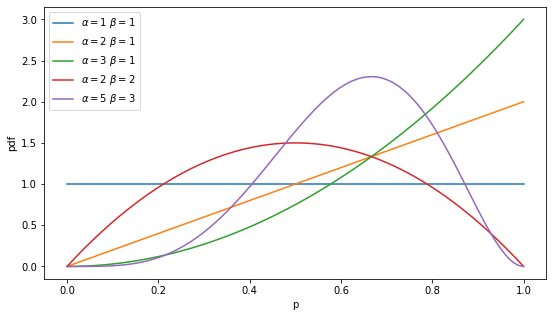

In [5]:
fig, ax = plt.subplots(figsize=(9, 5))
xpts = np.linspace(0, 1, 100)
for alpha, beta in [(1, 1), (2, 1), (3, 1), (2, 2), (5, 3)]:
    ax.plot(xpts, stats.beta(alpha, beta).pdf(xpts),
            label=f"$\\alpha={alpha}\\ \\beta={beta}$")
ax.set_ylabel('pdf')
ax.set_xlabel('p')
ax.legend();

To simplify the problem, we only consider *symmetric* Beta distributions, those for which $\alpha = \beta$.

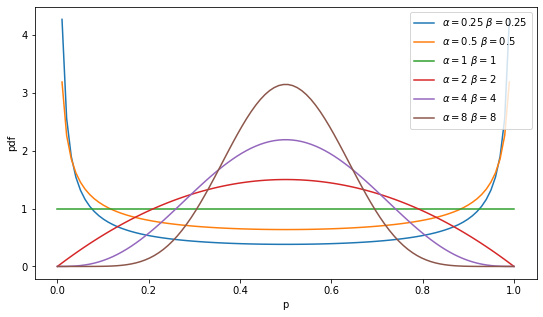

In [6]:
fig, ax = plt.subplots(figsize=(9, 5))
xpts = np.linspace(0, 1, 100)
for alpha, beta in [(0.25, 0.25),
                    (0.5, 0.5),
                    (1, 1), (2, 2),
                    (4, 4), (8, 8)]:
    ax.plot(xpts, stats.beta(alpha, beta).pdf(xpts),
            label=f"$\\alpha={alpha}\\ \\beta={beta}$")
ax.set_ylabel('pdf')
ax.set_xlabel('p')
ax.legend();

If we imagine the Beta distribution gives us probabilities between two options, a Dirichlet distribution returns probabilities between more choices.

Here are a few Dirichlet distributions returning probabilities between three options.

<img src="https://upload.wikimedia.org/wikipedia/commons/3/3e/Dirichlet_distributions.png" alt="various 3-category Dirichlet distributions" width=500 height=200 />

Here's the range of symmetric distributions, again for three options.

<img src="https://upload.wikimedia.org/wikipedia/commons/5/54/LogDirichletDensity-alpha_0.3_to_alpha_2.0.gif" alt="an animation of the range of 3-categoy symmetric Dirichlet distributions" />

In our model, we will assume that the probabilities of the document-topic distributions, and the probabilities of the topic-word distribution, are each drawn from symmetric Dirichlet distributions.

Each of those two symmetric Dirichlet distributions is described by a single (hyper)parameter. These govern how evenly each document is composed of topics, or each topic of words.

For example, if the topic-word hyperparameter is very large, then all words are pretty equally represented in each topic. If it's very small, each topic is dominated by a few words.

## Fitting the model

LDA is fit using an **expectation-maximization algorithm**. A simple example of such an algorithm is used in KMeans, in which we alternately choose and allocation of points to clusters (the latent variables), and then find the best cluster for the points.

In this case our latent variables are the probability each word in the training data comes from each a given topic. We start with randomly assigning an allocation, then finding the best mappings to fit that allocation, then reassign the allocation of words to topics, back and forth until we converge.


## Topic modeling

LDA is generally used for topic modeling, for discovering patterns with in our data. This might be part of EDA, or might be used to create additional features.

This has a lot of similarities to using NMF for topic modeling on a document as we talked about recently. In both cases, we take a single matrix (between documents and words) and turn it into two matrices (between documents and topics, and between topics and words) that when multiplied together, will return something like the original document.

There are significant differences in the original matrix, how the component matrices are created, and what they represent.

method | NMF | LDA
---------|---|-----
original matrix | TF-IDF | Bag of words
hyperparameters | # of topics | # number of topics, Dirichlet parameters
fitting method | ALS or SGD | EM
optimizes | RMSE | probability of generating words

## LDA in sklearn

Let's see how this can be used in topic modeling, with an `sklearn` dataset.

In [7]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [8]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
print(documents[42][:500])


OK, I've asked this before, and with a new thread on these lines, I
ask this again:

1: If a large hole current is run thru a resistor, will there be
   I^2 * R cooling instead of heating?

2: Can anyone design an amplifier that preferentially amplifies
   hole currents over normal electron currents?

3: what semiconductor materials have the highest ratio of
   hole mobility to electron mobility? (please quote actual
   test samples rather than estimates based on theory. Also,
   don't be limit


With LDA we use a `CountVectorizer` rather than TF-IDF, since we have a model in which we count words.

In [9]:
num_features = 1000

tf_vectorizer = CountVectorizer(max_df=0.95,
                                min_df=2,
                                max_features=num_features,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names() # theses are the words in our bag of words
tf

<11314x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 286231 stored elements in Compressed Sparse Row format>

We now create and fit an LDA model, using 10 topics. We'll leave the priors at the default.

In [10]:
num_topics = 10

lda = LatentDirichletAllocation(n_components=num_topics,
                                max_iter=5,
                                learning_method='online',
                                random_state=0,
                                n_jobs=-1)
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', max_iter=5, n_jobs=-1,
                          random_state=0)

In [11]:
lda.transform(tf).shape

(11314, 10)

In [12]:
lda.components_.shape

(10, 1000)

We can see what these topics look like. Do these make sense? 

In [13]:
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))

num_top_words = 12
display_topics(lda, tf_feature_names, num_top_words)

Topic 0:
people government gun armenian said armenians states war israel state turkish jews
Topic 1:
people don like point right make know think use just question time
Topic 2:
space program db output data entry nasa use build line science value
Topic 3:
key encryption chip government use keys public clipper security law bike privacy
Topic 4:
edu file com available information mail ftp files list send image email
Topic 5:
god people jesus does believe say think christian bible true life church
Topic 6:
windows use drive thanks does card problem like know using dos scsi
Topic 7:
ax max b8f g9v a86 pl 145 1d9 0t 34u 1t 3t
Topic 8:
just don like think know good time didn going ve ll got
Topic 9:
10 00 20 15 25 12 14 11 17 16 30 13
